# 1D Schrodinger equation
---
(Example From PINNs)

$$
\begin{aligned}
&ih_t + 0.5h_{xx} + |h|^2 h = 0, \ (x, t) \in [-5, 5]\times [0, \pi/2], \\ 
&h(0, x) = 2 \sech (x), \\
&h(t, -5) = h(t, 5), \\
&h_x(t, -5) = h_x(t, 5).
\end{aligned}
$$

Consider 
$$
h(t, x) = u(t, x) + iv(t, x), 
$$
where $u, v$ are real-valued functions. Then the equation can be given by

$$
\begin{aligned}
&u_t + 0.5v_{xx} + (u^2+v^2)v = 0, \\
&-v_t + 0.5u_{xx} + (u^2+v^2)u = 0, \\
&u(0, x) = 2\sech (x), \ v(0, x) = 0, \\
&u(t, -5) = u(t, 5), \ v(t, -5) = v(t, 5), \\
&u_x(t, -5) = u_x(t, 5), \ v_x(t, -5) = v_x(t, 5).
\end{aligned}
$$

In [1]:
NAME = "siren_new_derivative"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [3]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c0, w0, w1):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c0/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c0/m), m, n) for m, n, k in zip(layers[1:-2], layers[2:-1], keys[1:-2])] + \
			[siren_layer_params(keys[-1], w1*jnp.sqrt(c0/layers[-2]), layers[-2], layers[-1])]

def tanh_layer_params(key, m, n):
	w_key, b_key = random.split(key)
	w_init_fn = jax.nn.initializers.glorot_normal()
	return w_init_fn(w_key, (m, n), jnp.float32), jnp.zeros((n, ), jnp.float32)

def init_tanh_params(key, layers):
	keys = random.split(key, len(layers))
	return [tanh_layer_params(k, m, n) for (k, m, n) in zip(keys, layers[:-1], layers[1:])]

layers = [2, 100, 100, 100, 100, 2] # (x, t) -> (u, v)
c0 = 1.0
w0 = 2.0
w1 = 1.0
lambda_0 = 0
direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0, w1)
# direct_params = init_tanh_params(random.PRNGKey(0), layers)

domain = jnp.array([[-5, 0], [5, np.pi/2]]) # [(x0, t0), (x1, t1)]

# @jax.jit
# def model(params, xt):
# 	# first, normalize to [-1, 1]
# 	xt = 2.0*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - 1.0
# 	for w, b in params[:-1]:
# 		xt = jnp.tanh(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

@jax.jit
def model(params, xt):
	# first, normalize to [-1, 1]
	xt = 2.0*(xt - domain[0, :])/(domain[1, :]-domain[0, :]) - 1.0
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]
				   
jacobian = lambda params, xt: jax.jit(jax.vmap(jax.jacobian(model, 1), (None, 0)))(params, xt)
hessian = lambda params, xt: jax.jit(jax.vmap(jax.hessian(model, 1), (None, 0)))(params, xt)

In [4]:
# @jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

# @jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, periodic_bc = batch["collocation"], batch["dirichlet"], batch["periodic_bc"]
	direct_params = params
	
	uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
	u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
	
	# jacobian[i] = [[du/dx, du/dt],
	#                [dv/dx, dv/dt]]
	# i: the i^th input
	duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
	
	# hessian[i] = [
    #				[[du/dxx, du/dxy],
	#                [du/dxy, du/dyy]],
	#               [[dv/dxx, dv/dxy],
	#                [dv/dxy, dv/dyy]]
	#              ]
	duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0] 
	
	uv_l = model(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	uv_r = model(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	u_l, v_l = uv_l[:, 0:1], uv_l[:, 1:2]
	u_r, v_r = uv_r[:, 0:1], uv_r[:, 1:2]
	
	duv_dxt_l = jacobian(direct_params, jnp.hstack([periodic_bc.l, periodic_bc.t]))
	duv_dxt_r = jacobian(direct_params, jnp.hstack([periodic_bc.r, periodic_bc.t]))
	du_dx_l, dv_dx_l = duv_dxt_l[:, 0:1, 0], duv_dxt_l[:, 1:2, 0]
	du_dx_r, dv_dx_r = duv_dxt_r[:, 0:1, 0], duv_dxt_r[:, 1:2, 0]
		
	uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
	
# 	print(du_dt_c.shape, dv_dxx_c.shape, u_c.shape, v_c.shape)
# 	print(dv_dt_c.shape, du_dxx_c.shape)
# 	print(u_d.shape, v_d.shape, dirichlet.u.shape, dirichlet.v.shape)
# 	print(u_l.shape, u_r.shape, v_l.shape, v_r.shape, du_dx_l.shape, du_dx_r.shape, dv_dx_l.shape, dv_dx_r.shape)
	
	loss_c1 = mse(du_dt_c + 0.5*dv_dxx_c + (u_c**2 + v_c**2)*v_c, 0)
	loss_c2 = mse(-dv_dt_c + 0.5*du_dxx_c + (u_c**2 + v_c**2)*u_c, 0)
	loss_c = loss_c1 + loss_c2
	
	loss_d1 = mse(u_d, dirichlet.u)
	loss_d2 = mse(v_d, dirichlet.v)
	loss_d = loss_d1 + loss_d2
	
	loss_pbc_d1 = mse(u_l, u_r)
	loss_pbc_d2 = mse(v_l, v_r)
	loss_pbc_n1 = mse(du_dx_l, du_dx_r)
	loss_pbc_n2 = mse(dv_dx_l, dv_dx_r)
	loss_pbc_d = loss_pbc_d1 + loss_pbc_d2
	loss_pbc_n = loss_pbc_n1 + loss_pbc_n2
	
	return loss_c, loss_d, loss_pbc_d, loss_pbc_n

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n + l2_regularization(params, lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_pbc_d, loss_pbc_n = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["pbc_d"]*loss_pbc_d + w["pbc_n"]*loss_pbc_n, loss_c, loss_d, loss_pbc_d, loss_pbc_n

In [5]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

from scipy.io import loadmat
data = loadmat("NLS.mat")
x, t, h = data["x"].reshape((-1, 1)), data["tt"].reshape((-1, 1)), data["uu"].T
u, v = np.real(h), np.imag(h)

import pickle
with open("dataset_train.pkl", "rb") as file:
	[ix_i, ix_b, xt_c] = pickle.load(file)
	
# # ic
# n_i = 50
# ix_i = random.choice(subkeys[0], jnp.arange(len(x)), shape = (n_i, ), replace = False)
x_i = x[ix_i, :]
t_i = np.zeros_like(x_i)
u_i = u[0, ix_i].reshape((-1, 1))
v_i = v[0, ix_i].reshape((-1, 1))

# # bc
# n_b = 50
# ix_b = random.choice(subkeys[1], jnp.arange(len(t)), shape = (n_b, ), replace = False)
t_b = t[ix_b, :]
x_lb = np.ones_like(t_b)*domain[0, 0]
x_rb = np.ones_like(t_b)*domain[1, 0]

# n_c = 20000
# from pyDOE import lhs
# xt_c = lhs(2, n_c)
# x_c = transform(xt_c[:, 0:1], *domain[:, 0])
# t_c = transform(xt_c[:, 1:2], *domain[:, 1])
x_c, t_c = xt_c[:, 0:1], xt_c[:, 1:2]

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t"])

map_to_jnp_array = lambda x: map(lambda arr: jnp.array(arr), x)
dirichlet = dataset_Dirichlet(*map_to_jnp_array([x_i, t_i, u_i, v_i]))
periodic_bc = dataset_BC(*map_to_jnp_array([x_lb, x_rb, t_b]))
collocation = dataset_Collocation(*map_to_jnp_array([jnp.vstack([dirichlet.x, periodic_bc.l, periodic_bc.r, x_c]),
													jnp.vstack([dirichlet.t, periodic_bc.t, periodic_bc.t, t_c])]))

class Batch_Generator:
	def __init__(self, key, dataset, batch_size):
		self.key = key
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = jnp.arange(dataset[0].shape[0])
		self.pointer = 0
		self._shuffle()
		
	def _shuffle(self):
		key, subkey = random.split(self.key)
		self.index = random.permutation(subkey, jnp.arange(self.dataset[0].shape[0]))
		self.key = key
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			self._shuffle()
			self.pointer = 0
		self.pointer += self.batch_size
		index_ = self.index[self.pointer-self.batch_size:self.pointer]
		return [d[index_, :] for d in self.dataset]

In [6]:
lr = 1e-3
start_iteration = 0
iterations = 50000
print_every = 100
save_every = 50000
batch_size = {"dirichlet": 50, "bc": 50, "collocation": 20150}
weights = {"c": 1.0, "d": 1.0, "pbc_d": 1.0, "pbc_n": 1.0}

key, *subkeys = random.split(key, 4)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses[0])
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/02, 15:10:31, Iteration: 0, Train Loss: 7.3701e-01, c: 6.9231e-02, d: 6.6044e-01
2020/08/02, 15:10:34, Iteration: 100, Train Loss: 1.6733e-01, c: 5.3310e-02, d: 1.0893e-01
2020/08/02, 15:10:37, Iteration: 200, Train Loss: 7.2509e-02, c: 3.0775e-02, d: 3.6475e-02
2020/08/02, 15:10:40, Iteration: 300, Train Loss: 5.7974e-02, c: 3.0298e-02, d: 2.7468e-02
2020/08/02, 15:10:43, Iteration: 400, Train Loss: 6.2165e-02, c: 2.9278e-02, d: 2.7440e-02
2020/08/02, 15:10:46, Iteration: 500, Train Loss: 5.6239e-02, c: 3.0292e-02, d: 2.1612e-02
2020/08/02, 15:10:49, Iteration: 600, Train Loss: 4.7317e-02, c: 2.8338e-02, d: 1.8853e-02
2020/08/02, 15:10:51, Iteration: 700, Train Loss: 4.9086e-02, c: 3.1263e-02, d: 1.7425e-02
2020/08/02, 15:10:54, Iteration: 800, Train Loss: 4.7529e-02, c: 2.8210e-02, d: 1.8217e-02
2020/08/02, 15:10:57, Iteration: 900, Train Loss: 3.3115e-02, c: 1.9575e-02, d: 1.3471e-02
2020/08/02, 15:11:00, Iteration: 1000, Train Loss: 2.9700e-02, c: 1.7061e-02, d: 1.2590e-02


2020/08/02, 15:14:53, Iteration: 9000, Train Loss: 7.4831e-04, c: 5.5808e-04, d: 7.9168e-05
2020/08/02, 15:14:56, Iteration: 9100, Train Loss: 3.8559e-04, c: 2.8510e-04, d: 8.1619e-05
2020/08/02, 15:14:59, Iteration: 9200, Train Loss: 4.0665e-03, c: 3.8833e-03, d: 5.2787e-05
2020/08/02, 15:15:02, Iteration: 9300, Train Loss: 3.3170e-04, c: 2.4953e-04, d: 8.0297e-05
2020/08/02, 15:15:05, Iteration: 9400, Train Loss: 1.0674e-02, c: 1.0044e-02, d: 1.6782e-04
2020/08/02, 15:15:08, Iteration: 9500, Train Loss: 5.7037e-04, c: 4.6343e-04, d: 6.1768e-05
2020/08/02, 15:15:11, Iteration: 9600, Train Loss: 3.0896e-04, c: 2.1192e-04, d: 6.7140e-05
2020/08/02, 15:15:14, Iteration: 9700, Train Loss: 1.8032e-03, c: 1.7206e-03, d: 3.7183e-05
2020/08/02, 15:15:16, Iteration: 9800, Train Loss: 3.2371e-03, c: 3.1437e-03, d: 3.9238e-05
2020/08/02, 15:15:19, Iteration: 9900, Train Loss: 4.0784e-04, c: 3.5378e-04, d: 5.0322e-05
2020/08/02, 15:15:22, Iteration: 10000, Train Loss: 4.8658e-04, c: 4.0627e-04, d

2020/08/02, 15:19:10, Iteration: 17900, Train Loss: 1.2215e-04, c: 8.2691e-05, d: 2.0137e-05
2020/08/02, 15:19:13, Iteration: 18000, Train Loss: 7.2460e-05, c: 5.5147e-05, d: 1.6198e-05
2020/08/02, 15:19:16, Iteration: 18100, Train Loss: 7.2039e-05, c: 5.5757e-05, d: 1.4774e-05
2020/08/02, 15:19:19, Iteration: 18200, Train Loss: 1.0374e-04, c: 7.6745e-05, d: 2.2445e-05
2020/08/02, 15:19:22, Iteration: 18300, Train Loss: 7.9159e-05, c: 6.0876e-05, d: 1.6039e-05
2020/08/02, 15:19:25, Iteration: 18400, Train Loss: 1.2663e-04, c: 1.0057e-04, d: 1.6924e-05
2020/08/02, 15:19:28, Iteration: 18500, Train Loss: 7.6089e-05, c: 5.5584e-05, d: 1.4942e-05
2020/08/02, 15:19:31, Iteration: 18600, Train Loss: 2.9697e-04, c: 2.7593e-04, d: 1.9610e-05
2020/08/02, 15:19:34, Iteration: 18700, Train Loss: 2.0741e-04, c: 1.8290e-04, d: 1.6744e-05
2020/08/02, 15:19:36, Iteration: 18800, Train Loss: 8.2103e-05, c: 6.4579e-05, d: 1.3642e-05
2020/08/02, 15:19:39, Iteration: 18900, Train Loss: 4.8820e-04, c: 2.3

2020/08/02, 15:23:27, Iteration: 26800, Train Loss: 1.3350e-04, c: 1.0935e-04, d: 1.3981e-05
2020/08/02, 15:23:30, Iteration: 26900, Train Loss: 3.6464e-04, c: 3.4926e-04, d: 1.3850e-05
2020/08/02, 15:23:33, Iteration: 27000, Train Loss: 6.6760e-04, c: 4.4379e-04, d: 6.8820e-05
2020/08/02, 15:23:36, Iteration: 27100, Train Loss: 8.6395e-04, c: 8.2528e-04, d: 1.8668e-05
2020/08/02, 15:23:39, Iteration: 27200, Train Loss: 4.6363e-04, c: 4.1101e-04, d: 3.1629e-05
2020/08/02, 15:23:42, Iteration: 27300, Train Loss: 8.2057e-05, c: 7.4225e-05, d: 7.3602e-06
2020/08/02, 15:23:45, Iteration: 27400, Train Loss: 3.7993e-05, c: 3.1280e-05, d: 6.0640e-06
2020/08/02, 15:23:47, Iteration: 27500, Train Loss: 7.0615e-05, c: 5.9705e-05, d: 7.6391e-06
2020/08/02, 15:23:50, Iteration: 27600, Train Loss: 6.2627e-04, c: 4.7939e-04, d: 6.5062e-05
2020/08/02, 15:23:53, Iteration: 27700, Train Loss: 9.7677e-04, c: 9.2089e-04, d: 3.2440e-05
2020/08/02, 15:23:56, Iteration: 27800, Train Loss: 7.0757e-05, c: 6.1

2020/08/02, 15:27:44, Iteration: 35700, Train Loss: 2.6498e-04, c: 2.4618e-04, d: 1.3116e-05
2020/08/02, 15:27:47, Iteration: 35800, Train Loss: 4.4776e-05, c: 3.1209e-05, d: 4.8965e-06
2020/08/02, 15:27:50, Iteration: 35900, Train Loss: 3.5498e-05, c: 2.9661e-05, d: 4.3270e-06
2020/08/02, 15:27:53, Iteration: 36000, Train Loss: 3.2280e-04, c: 2.5825e-04, d: 5.0093e-05
2020/08/02, 15:27:56, Iteration: 36100, Train Loss: 1.3116e-03, c: 1.2816e-03, d: 2.1435e-05
2020/08/02, 15:27:59, Iteration: 36200, Train Loss: 5.9143e-04, c: 5.2766e-04, d: 2.9492e-05
2020/08/02, 15:28:02, Iteration: 36300, Train Loss: 4.1588e-03, c: 2.1640e-03, d: 5.9229e-04
2020/08/02, 15:28:04, Iteration: 36400, Train Loss: 2.8224e-05, c: 2.4572e-05, d: 3.4335e-06
2020/08/02, 15:28:07, Iteration: 36500, Train Loss: 3.3548e-05, c: 3.0587e-05, d: 2.7340e-06
2020/08/02, 15:28:10, Iteration: 36600, Train Loss: 1.0132e-03, c: 9.8466e-04, d: 7.1687e-06
2020/08/02, 15:28:13, Iteration: 36700, Train Loss: 2.5512e-04, c: 2.3

2020/08/02, 15:32:01, Iteration: 44600, Train Loss: 5.8551e-04, c: 5.6054e-04, d: 1.4336e-05
2020/08/02, 15:32:04, Iteration: 44700, Train Loss: 1.1849e-03, c: 1.1324e-03, d: 3.7366e-05
2020/08/02, 15:32:07, Iteration: 44800, Train Loss: 1.0820e-03, c: 9.0915e-04, d: 4.5145e-05
2020/08/02, 15:32:10, Iteration: 44900, Train Loss: 3.3151e-04, c: 3.2705e-04, d: 3.4586e-06
2020/08/02, 15:32:13, Iteration: 45000, Train Loss: 1.3240e-04, c: 1.2666e-04, d: 4.4963e-06
2020/08/02, 15:32:16, Iteration: 45100, Train Loss: 1.9140e-05, c: 1.4796e-05, d: 4.0081e-06
2020/08/02, 15:32:19, Iteration: 45200, Train Loss: 4.5297e-05, c: 3.8842e-05, d: 2.9298e-06
2020/08/02, 15:32:22, Iteration: 45300, Train Loss: 2.5802e-04, c: 2.4540e-04, d: 1.0302e-05
2020/08/02, 15:32:25, Iteration: 45400, Train Loss: 8.1498e-04, c: 7.7756e-04, d: 2.7718e-05
2020/08/02, 15:32:27, Iteration: 45500, Train Loss: 1.4513e-04, c: 9.8298e-05, d: 1.4827e-05
2020/08/02, 15:32:30, Iteration: 45600, Train Loss: 1.3811e-04, c: 1.2

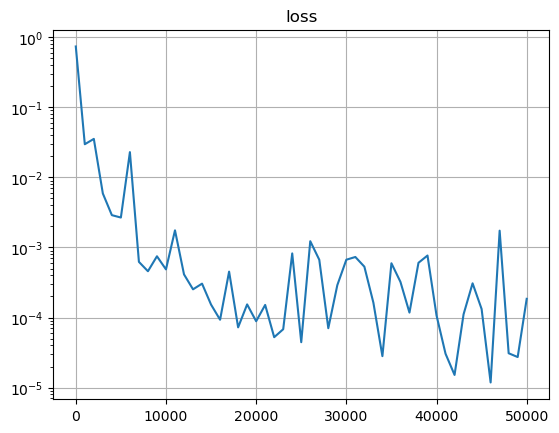

In [7]:
from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

plt.semilogy(hist["iter"][::10], hist["loss"][::10])
plt.title("loss")
plt.grid()
plt.show()

In [6]:
iteration = 50000
direct_params = np.load("models/{}/iteration_{}/params.npy".format(NAME, iteration), allow_pickle=True)
direct_params = [[jnp.asarray(arr) for arr in Arr] for Arr in direct_params]

<IPython.core.display.Javascript object>


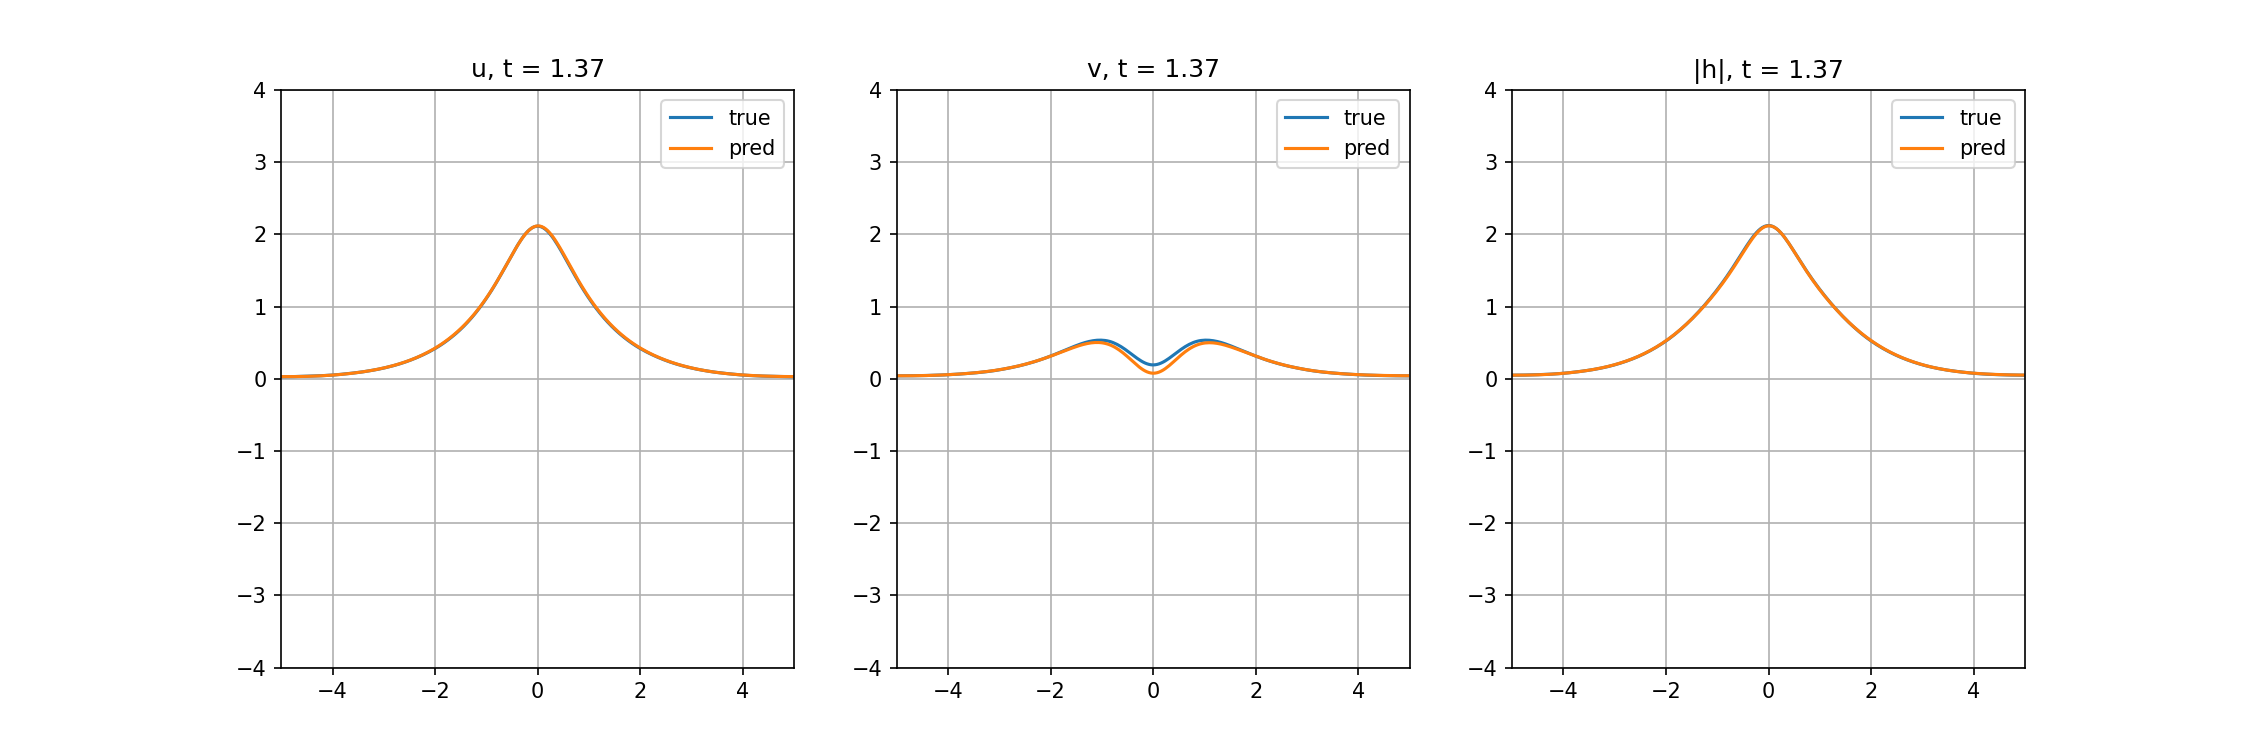

In [7]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([-5, 5])
    ax[i].set_ylim([-4, 4])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

xt_tests = [tensor_grid([x, ti]) for ti in t]
uv_preds = [model(direct_params, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = u[i, :], v[i, :]
	
	lines[0].set_data(x, u_true)
	lines[1].set_data(x, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t[i, 0]))
    
	lines[2].set_data(x, v_true)
	lines[3].set_data(x, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t[i, 0]))

	lines[4].set_data(x, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t[i, 0]))

	return lines

anim = animation.FuncAnimation(fig, animate, init_func = init, 
								   frames = len(t), interval = 200, blit = True)
plt.show()

In [10]:
direct_params

[[DeviceArray([[-0.665224  ,  1.529742  , -0.40923682, -1.352988  ,
                 1.1970543 ,  1.4561625 ,  1.6735526 ,  0.28755447,
                -1.4543655 , -0.3701407 ,  0.42369375, -1.4872054 ,
                 1.6336485 , -1.3780515 ,  0.5500212 , -0.9841035 ,
                 0.8277752 , -1.5083456 , -0.8255421 ,  1.2089072 ,
                 1.4982244 , -0.0333157 , -1.5002347 , -0.0360618 ,
                -0.34860012, -1.3211445 ,  0.25538552, -0.1092646 ,
                 0.23540974,  1.346602  ,  0.16887765,  0.18682456,
                 1.282156  ,  0.4451166 ,  0.8677078 ,  0.88871104,
                 0.18271938, -0.53960556, -0.53081036,  0.4257477 ,
                 1.314831  ,  1.4471577 ,  1.1445646 ,  0.27816558,
                 0.17706259, -1.1661342 ,  0.8411193 , -0.04013107,
                -0.51663834, -1.2220616 , -0.6712297 ,  0.23788875,
                 0.75177807,  0.8899478 ,  0.46814564,  1.555842  ,
                 0.898612  ,  1.5168941 , -1.365